# Computer Vision: Assignment 3 Part 1 - Some CNN Basics [50%]

Spring 2022 semester.

Due date: **July 1st 2022.**

## Introduction

This question is an introduction to using PyTorch for training simple neural net models. 

Two different datasets will be used: 
- MNIST digits [handwritten digits]
- CIFAR-10 [32x32 resolution color images of 10 object classes].

## Requirements

Perform this assignment in PyTorch, modifying the baseline code, producing outputs and adding required explanations - *all within this ipython notebook*.

Finally, submit this iPython notebook, including outputs, as an .ipynb file. 

## Question (1): Warmup [5%]

It is always good practice to visually inspect your data before trying to train a model, since it lets you check for problems and get a feel for the task at hand.

MNIST is a dataset of 70,000 grayscale hand-written digits (0 through 9).
60,000 of these are training images. 10,000 are a held out test set. 

CIFAR-10 is a dataset of 60,000 color images (32 by 32 resolution) across 10 classes (airplane, automobile, bird, cat, deer, dog, frog, horse, ship, truck). 
The train/test split is 50k/10k.

**a)**  Use `matplotlib` and ipython notebook's visualization capabilities to display the average train and average test image of each class, for each of the two datasets.
[See this PyTorch tutorial page](http://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html#sphx-glr-beginner-blitz-cifar10-tutorial-py) for hints on how to achieve this.

## Question (2): Training a Single Layer Network on MNIST [10%]

Start by running the training on MNIST. By default if you run this notebook successfully, it will train on MNIST.

This will initialize a single layer model train it on the 60,000 MNIST training images for 10 epochs (passes through the training data). 

The cross-entropy loss function computes a Logarithm of the Softmax on the output of the neural network, and then computes the negative log-likelihood w.r.t. the given target.

The default values for the learning rate, batch size and number of epochs are given in the "options" cell of this notebook. Unless otherwise specified, use the default values throughout this assignment. 

Note the decrease in training loss and corresponding decrease in validation errors.

**a)** Add code to plot out the network weights as images (one for each class, of size 28 by 28) after the last epoch. (Hint thread: [#1](https://discuss.pytorch.org/t/understanding-deep-network-visualize-weights/2060/2?u=smth) )

**b)** Reduce the number of training examples to just 50. [Hint: limit the iterator in the `train` function]. 
Paste the output into your report and explain what is happening to the model.

## Question (3): Training a Multi-Layer Network on MNIST [10%]

**a)**  Add an extra layer to the network with 1000 hidden units and a `tanh` non-linearity. [Hint: modify the `Net` class].

**b)**   Now retrain the model for 10 epochs with each of the learning rates in the set {0.01, 0.1, 1, 10} and test the resulting model. Create a figure and plot the loss curves of each of the four runs for comparison. Explain the obtained (train and test) results.

## Question (4): Training a Convolutional Network on CIFAR [15%]

To change over to the CIFAR-10 dataset, change the `options` cell's `dataset` variable to `'cifar10'`.

- Create a convolutional network with the following architecture:
  - Convolution with 5 by 5 filters, stride 2, 16 feature maps + Tanh nonlinearity.
  - Convolution with 3 by 3 filters, (stride 1), 64 feature maps + Tanh nonlinearity.
  - Convolution with 3 by 3 filters, (stride 1), 64 feature maps + Tanh nonlinearity.
  - 2 by 2 max pooling (non-overlapping).
  - Flatten to vector.
  - Linear layer with 64 hidden units + Tanh nonlinearity.
  - Linear layer to 10 output units.

**a)** Train it for 20 epochs on CIFAR-10 and plot the training loss curve (avg. loss per epoch) and final test loss and accuracy, when training with or without the two 3x3 convolutional layers. 

**b)**  Give a breakdown of the number of parameters (per layer) within the above model, as well as the overall number.

# **Answer (1):**
create needed blocks of code (and results) below

In [5]:
# imports
from __future__ import print_function
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
import torchvision.models as models

import torchvision
import matplotlib.pyplot as plt
import numpy as np

In [6]:
def imshow(img1, img2, dataset, label):
    img1 = img1 / 2 + 0.5  # un-normalize
    img2 = img2 / 2 + 0.5
    np_img1, np_img2 = img1.numpy(), img2.numpy()

    plt.figure()
    plt.suptitle(dataset + " dataset average: Class " + label)
    plt.subplot(1, 2, 1)
    plt.imshow(np.transpose(np_img1, (1, 2, 0)))
    plt.title('Train')
    plt.subplot(1, 2, 2)
    plt.imshow(np.transpose(np_img2, (1, 2, 0)))
    plt.title('Test')
    plt.show()

In [7]:
def show_average_image(train_loader, test_loader, dataset, labels):
    
    train_counters, test_counters = [], []
    train_results, test_results = [], []
    
    for _ in range(len(labels)):
        train_counters.append(0)
        test_counters.append(0)
        train_results.append(None)
        test_results.append(None)
    
    dataiter = iter(train_loader)
    
    while True:
        try:
            img_temp, label_temp = dataiter.next()
            
            for ind in range(len(labels)):
                if str(label_temp) == 'tensor([' + str(ind) + '])':
                    train_counters[ind] += 1
                    if train_results[ind] is None:
                        train_results[ind] = img_temp
                    else:
                        train_results[ind] += img_temp

        except StopIteration:
            break

    dataiter = iter(test_loader)
    
    while True:
        try:
            img_temp, label_temp = dataiter.next()
            
            for ind in range(len(labels)):
                if str(label_temp) == 'tensor([' + str(ind) + '])':
                    test_counters[ind] += 1
                    if test_results[ind] is None:
                        test_results[ind] = img_temp
                    else:
                        test_results[ind] += img_temp

        except StopIteration:
            break
        
    for index, label in enumerate(labels):
        
        test_results[index] /= test_counters[index]
        train_results[index] /= train_counters[index]

        imshow(torchvision.utils.make_grid(train_results[index]), torchvision.utils.make_grid(test_results[index]), 
               dataset, labels[index])

Files already downloaded and verified
Files already downloaded and verified


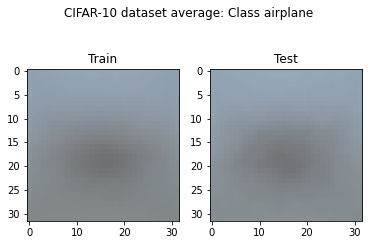

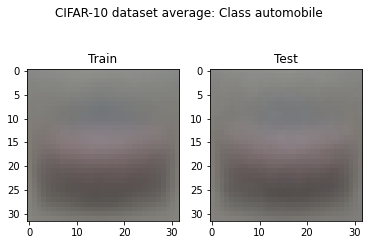

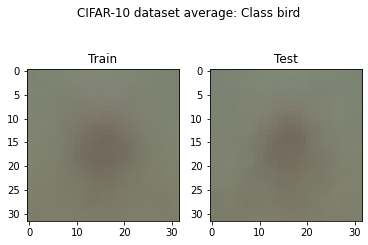

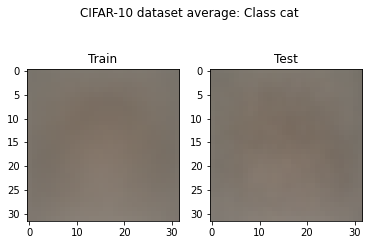

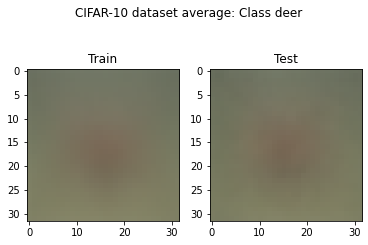

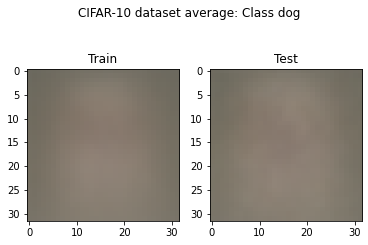

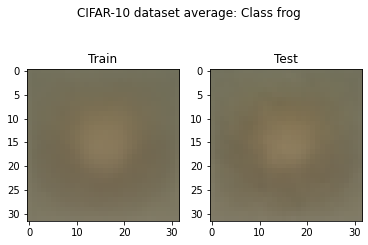

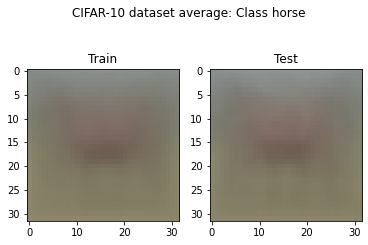

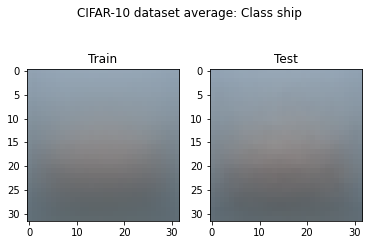

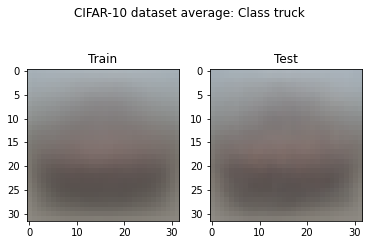

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


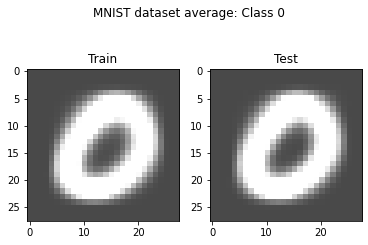

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


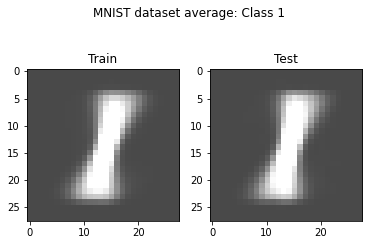

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


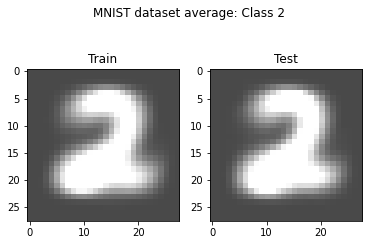

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


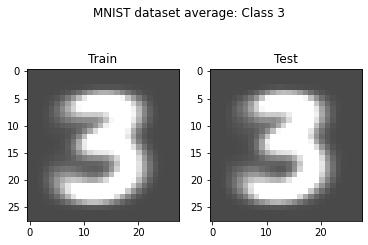

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


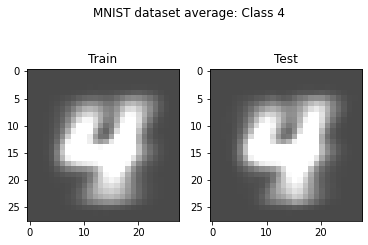

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


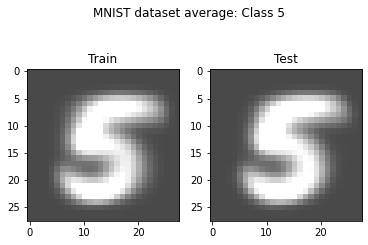

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


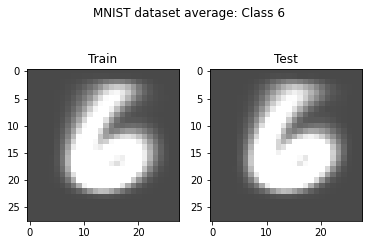

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


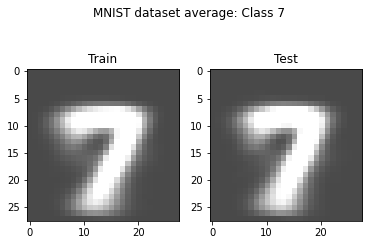

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


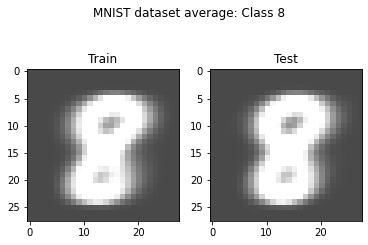

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


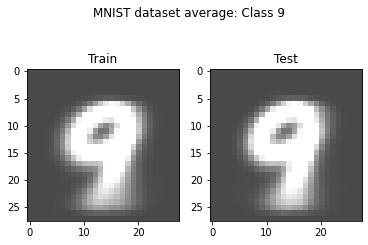

In [8]:
torch.utils.data.DataLoader.num_worker = 0

cifar_transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

mnist_transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))])

cifar_train = torchvision.datasets.CIFAR10(root='.', train=True,
                                           download=True, transform=cifar_transform)

cifar_train_loader = torch.utils.data.DataLoader(cifar_train, batch_size=1,
                                                 shuffle=True, num_workers=2)

cifar_test = torchvision.datasets.CIFAR10(root='.', train=False,
                                          download=True, transform=cifar_transform)

cifar_test_loader = torch.utils.data.DataLoader(cifar_test, batch_size=1,
                                                shuffle=False, num_workers=2)

mnist_train = torchvision.datasets.MNIST(root='.', train=True,
                                         download=True, transform=mnist_transform)

mnist_train_loader = torch.utils.data.DataLoader(mnist_train, batch_size=1,
                                                 shuffle=True, num_workers=2)

mnist_test = torchvision.datasets.MNIST(root='.', train=False,
                                        download=True, transform=mnist_transform)

mnist_test_loader = torch.utils.data.DataLoader(mnist_test, batch_size=1,
                                                shuffle=False, num_workers=2)

cifar_labels = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
mnist_labels = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']

show_average_image(cifar_train_loader, cifar_test_loader, 'CIFAR-10', cifar_labels)
show_average_image(mnist_train_loader, mnist_test_loader, 'MNIST', mnist_labels)

# **Answer (2):**
create needed blocks of code (and results) below

In [9]:
# options
dataset = 'mnist' # options: 'mnist' | 'cifar10'
batch_size = 64   # input batch size for training
epochs = 10       # number of epochs to train
lr = 0.01        # learning rate

In [10]:
## network and optimizer
if dataset == 'mnist':
    num_inputs = 784
elif dataset == 'cifar10':
    num_inputs = 3072

num_outputs = 10 # same for both CIFAR10 and MNIST, both have 10 classes as outputs

class Net(nn.Module):
    def __init__(self, num_inputs, num_outputs):
        super(Net, self).__init__()
        self.linear = nn.Linear(num_inputs, num_outputs)

    def forward(self, input):
        input = input.view(-1, num_inputs) # reshape input to batch x num_inputs
        output = self.linear(input)
        return output

network = Net(num_inputs, num_outputs)
optimizer = optim.SGD(network.parameters(), lr=lr)

In [11]:
# train and test functions
def train(epoch, train_loader):
    network.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = Variable(data), Variable(target)
        optimizer.zero_grad()
        output = network(data)
        loss = F.cross_entropy(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))

def test(test_loader):
    network.eval()
    test_loss = 0
    correct = 0
    for data, target in test_loader:
        #data, target = Variable(data, volatile=True), Variable(target)
        output = network(data)
        test_loss += F.cross_entropy(output, target, reduction='sum').item() # sum up batch loss
        #test_loss += F.cross_entropy(output, target, sum=True).item() # sum up batch loss
        pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
        correct += pred.eq(target.data.view_as(pred)).cpu().sum()

    test_loss /= len(test_loader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))


In [ ]:
# Training and testing 
for i in range(1, epochs+1):
  train(i, mnist_train_loader)

test(mnist_test_loader)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.082716
Train Epoch: 1 [100/60000 (0%)]	Loss: 0.416188
Train Epoch: 1 [200/60000 (0%)]	Loss: 4.835034
Train Epoch: 1 [300/60000 (0%)]	Loss: 0.000860
Train Epoch: 1 [400/60000 (1%)]	Loss: 0.291163
Train Epoch: 1 [500/60000 (1%)]	Loss: 0.000002
Train Epoch: 1 [600/60000 (1%)]	Loss: 3.509004
Train Epoch: 1 [700/60000 (1%)]	Loss: 0.981590
Train Epoch: 1 [800/60000 (1%)]	Loss: 0.128686
Train Epoch: 1 [900/60000 (2%)]	Loss: 0.117640
Train Epoch: 1 [1000/60000 (2%)]	Loss: 0.012094
Train Epoch: 1 [1100/60000 (2%)]	Loss: 0.016753
Train Epoch: 1 [1200/60000 (2%)]	Loss: 8.103202
Train Epoch: 1 [1300/60000 (2%)]	Loss: 0.015313
Train Epoch: 1 [1400/60000 (2%)]	Loss: 0.008791
Train Epoch: 1 [1500/60000 (2%)]	Loss: 0.000074
Train Epoch: 1 [1600/60000 (3%)]	Loss: 0.000013
Train Epoch: 1 [1700/60000 (3%)]	Loss: 0.000064
Train Epoch: 1 [1800/60000 (3%)]	Loss: 0.001401
Train Epoch: 1 [1900/60000 (3%)]	Loss: 0.139472
Train Epoch: 1 [2000/60000 (3%)]	Loss: 14.357430
Tra

Train Epoch: 1 [17100/60000 (28%)]	Loss: 12.890178
Train Epoch: 1 [17200/60000 (29%)]	Loss: 4.667087
Train Epoch: 1 [17300/60000 (29%)]	Loss: 0.003494
Train Epoch: 1 [17400/60000 (29%)]	Loss: 0.000017
Train Epoch: 1 [17500/60000 (29%)]	Loss: 0.000150
Train Epoch: 1 [17600/60000 (29%)]	Loss: 0.000988
Train Epoch: 1 [17700/60000 (30%)]	Loss: 0.000419
Train Epoch: 1 [17800/60000 (30%)]	Loss: 0.000000
Train Epoch: 1 [17900/60000 (30%)]	Loss: 0.093270
Train Epoch: 1 [18000/60000 (30%)]	Loss: 8.411927
Train Epoch: 1 [18100/60000 (30%)]	Loss: 0.055615
Train Epoch: 1 [18200/60000 (30%)]	Loss: 0.000576
Train Epoch: 1 [18300/60000 (30%)]	Loss: 0.001065
Train Epoch: 1 [18400/60000 (31%)]	Loss: 0.000070
Train Epoch: 1 [18500/60000 (31%)]	Loss: 0.522026
Train Epoch: 1 [18600/60000 (31%)]	Loss: 0.772726
Train Epoch: 1 [18700/60000 (31%)]	Loss: 0.074102
Train Epoch: 1 [18800/60000 (31%)]	Loss: 0.000019
Train Epoch: 1 [18900/60000 (32%)]	Loss: 0.001669
Train Epoch: 1 [19000/60000 (32%)]	Loss: 0.000003

Train Epoch: 1 [33900/60000 (56%)]	Loss: 0.000103
Train Epoch: 1 [34000/60000 (57%)]	Loss: 0.000001
Train Epoch: 1 [34100/60000 (57%)]	Loss: 4.363986
Train Epoch: 1 [34200/60000 (57%)]	Loss: 0.000239
Train Epoch: 1 [34300/60000 (57%)]	Loss: 0.322173
Train Epoch: 1 [34400/60000 (57%)]	Loss: 0.911850
Train Epoch: 1 [34500/60000 (58%)]	Loss: 4.393237
Train Epoch: 1 [34600/60000 (58%)]	Loss: 0.000029
Train Epoch: 1 [34700/60000 (58%)]	Loss: 0.001226
Train Epoch: 1 [34800/60000 (58%)]	Loss: 1.161400
Train Epoch: 1 [34900/60000 (58%)]	Loss: 4.988175
Train Epoch: 1 [35000/60000 (58%)]	Loss: 0.000000
Train Epoch: 1 [35100/60000 (58%)]	Loss: 0.094400
Train Epoch: 1 [35200/60000 (59%)]	Loss: 0.002103
Train Epoch: 1 [35300/60000 (59%)]	Loss: 0.041841
Train Epoch: 1 [35400/60000 (59%)]	Loss: 0.016840
Train Epoch: 1 [35500/60000 (59%)]	Loss: 0.000260
Train Epoch: 1 [35600/60000 (59%)]	Loss: 0.000005
Train Epoch: 1 [35700/60000 (60%)]	Loss: 0.000001
Train Epoch: 1 [35800/60000 (60%)]	Loss: 0.004111


Train Epoch: 1 [50400/60000 (84%)]	Loss: 13.543007
Train Epoch: 1 [50500/60000 (84%)]	Loss: 0.012822
Train Epoch: 1 [50600/60000 (84%)]	Loss: 0.025891
Train Epoch: 1 [50700/60000 (84%)]	Loss: 0.000002
Train Epoch: 1 [50800/60000 (85%)]	Loss: 0.000001
Train Epoch: 1 [50900/60000 (85%)]	Loss: 0.000002
Train Epoch: 1 [51000/60000 (85%)]	Loss: 0.000114
Train Epoch: 1 [51100/60000 (85%)]	Loss: 0.000075
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.000037
Train Epoch: 1 [51300/60000 (86%)]	Loss: 0.000000
Train Epoch: 1 [51400/60000 (86%)]	Loss: 0.000000
Train Epoch: 1 [51500/60000 (86%)]	Loss: 0.007628
Train Epoch: 1 [51600/60000 (86%)]	Loss: 0.000000
Train Epoch: 1 [51700/60000 (86%)]	Loss: 0.354228
Train Epoch: 1 [51800/60000 (86%)]	Loss: 0.004527
Train Epoch: 1 [51900/60000 (86%)]	Loss: 0.029084
Train Epoch: 1 [52000/60000 (87%)]	Loss: 0.000002
Train Epoch: 1 [52100/60000 (87%)]	Loss: 1.741613
Train Epoch: 1 [52200/60000 (87%)]	Loss: 0.000001
Train Epoch: 1 [52300/60000 (87%)]	Loss: 0.000093

Train Epoch: 2 [7600/60000 (13%)]	Loss: 0.000000
Train Epoch: 2 [7700/60000 (13%)]	Loss: 0.046975
Train Epoch: 2 [7800/60000 (13%)]	Loss: 0.000066
Train Epoch: 2 [7900/60000 (13%)]	Loss: 0.000002
Train Epoch: 2 [8000/60000 (13%)]	Loss: 0.000023
Train Epoch: 2 [8100/60000 (14%)]	Loss: 2.185203
Train Epoch: 2 [8200/60000 (14%)]	Loss: 0.000000
Train Epoch: 2 [8300/60000 (14%)]	Loss: 0.000000
Train Epoch: 2 [8400/60000 (14%)]	Loss: 0.010276
Train Epoch: 2 [8500/60000 (14%)]	Loss: 0.000001
Train Epoch: 2 [8600/60000 (14%)]	Loss: 0.000000
Train Epoch: 2 [8700/60000 (14%)]	Loss: 4.686153
Train Epoch: 2 [8800/60000 (15%)]	Loss: 0.001001
Train Epoch: 2 [8900/60000 (15%)]	Loss: 0.002344
Train Epoch: 2 [9000/60000 (15%)]	Loss: 0.000001
Train Epoch: 2 [9100/60000 (15%)]	Loss: 0.000041
Train Epoch: 2 [9200/60000 (15%)]	Loss: 0.000000
Train Epoch: 2 [9300/60000 (16%)]	Loss: 0.003324
Train Epoch: 2 [9400/60000 (16%)]	Loss: 0.000000
Train Epoch: 2 [9500/60000 (16%)]	Loss: 0.000329
Train Epoch: 2 [9600

Train Epoch: 2 [24100/60000 (40%)]	Loss: 0.000004
Train Epoch: 2 [24200/60000 (40%)]	Loss: 0.009418
Train Epoch: 2 [24300/60000 (40%)]	Loss: 0.170459
Train Epoch: 2 [24400/60000 (41%)]	Loss: 0.000000
Train Epoch: 2 [24500/60000 (41%)]	Loss: 0.000000
Train Epoch: 2 [24600/60000 (41%)]	Loss: 0.000000
Train Epoch: 2 [24700/60000 (41%)]	Loss: 0.000000
Train Epoch: 2 [24800/60000 (41%)]	Loss: 0.313949
Train Epoch: 2 [24900/60000 (42%)]	Loss: 0.000000
Train Epoch: 2 [25000/60000 (42%)]	Loss: 0.000308
Train Epoch: 2 [25100/60000 (42%)]	Loss: 0.000000
Train Epoch: 2 [25200/60000 (42%)]	Loss: 0.000001
Train Epoch: 2 [25300/60000 (42%)]	Loss: 0.000048
Train Epoch: 2 [25400/60000 (42%)]	Loss: 0.000001
Train Epoch: 2 [25500/60000 (42%)]	Loss: 0.000347
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.000000
Train Epoch: 2 [25700/60000 (43%)]	Loss: 0.000015
Train Epoch: 2 [25800/60000 (43%)]	Loss: 0.000000
Train Epoch: 2 [25900/60000 (43%)]	Loss: 0.000173
Train Epoch: 2 [26000/60000 (43%)]	Loss: 0.000010


Train Epoch: 2 [40700/60000 (68%)]	Loss: 0.000026
Train Epoch: 2 [40800/60000 (68%)]	Loss: 0.000007
Train Epoch: 2 [40900/60000 (68%)]	Loss: 0.000003
Train Epoch: 2 [41000/60000 (68%)]	Loss: 0.000000
Train Epoch: 2 [41100/60000 (68%)]	Loss: 10.889394
Train Epoch: 2 [41200/60000 (69%)]	Loss: 0.000056
Train Epoch: 2 [41300/60000 (69%)]	Loss: 0.000000
Train Epoch: 2 [41400/60000 (69%)]	Loss: 0.173665
Train Epoch: 2 [41500/60000 (69%)]	Loss: 0.000007
Train Epoch: 2 [41600/60000 (69%)]	Loss: 0.000000
Train Epoch: 2 [41700/60000 (70%)]	Loss: 0.000001
Train Epoch: 2 [41800/60000 (70%)]	Loss: 0.000000
Train Epoch: 2 [41900/60000 (70%)]	Loss: 0.000000
Train Epoch: 2 [42000/60000 (70%)]	Loss: 0.000000
Train Epoch: 2 [42100/60000 (70%)]	Loss: 0.893500
Train Epoch: 2 [42200/60000 (70%)]	Loss: 0.000053
Train Epoch: 2 [42300/60000 (70%)]	Loss: 2.407708
Train Epoch: 2 [42400/60000 (71%)]	Loss: 0.006121
Train Epoch: 2 [42500/60000 (71%)]	Loss: 15.111600
Train Epoch: 2 [42600/60000 (71%)]	Loss: 0.00124

Train Epoch: 2 [57200/60000 (95%)]	Loss: 0.000113
Train Epoch: 2 [57300/60000 (96%)]	Loss: 0.000000
Train Epoch: 2 [57400/60000 (96%)]	Loss: 0.000023
Train Epoch: 2 [57500/60000 (96%)]	Loss: 0.002694
Train Epoch: 2 [57600/60000 (96%)]	Loss: 0.000000
Train Epoch: 2 [57700/60000 (96%)]	Loss: 0.000000
Train Epoch: 2 [57800/60000 (96%)]	Loss: 0.087155
Train Epoch: 2 [57900/60000 (96%)]	Loss: 0.000162
Train Epoch: 2 [58000/60000 (97%)]	Loss: 1.006602
Train Epoch: 2 [58100/60000 (97%)]	Loss: 0.001959
Train Epoch: 2 [58200/60000 (97%)]	Loss: 0.000004
Train Epoch: 2 [58300/60000 (97%)]	Loss: 0.425587
Train Epoch: 2 [58400/60000 (97%)]	Loss: 0.012117
Train Epoch: 2 [58500/60000 (98%)]	Loss: 0.000037
Train Epoch: 2 [58600/60000 (98%)]	Loss: 3.216259
Train Epoch: 2 [58700/60000 (98%)]	Loss: 0.000000
Train Epoch: 2 [58800/60000 (98%)]	Loss: 0.000132
Train Epoch: 2 [58900/60000 (98%)]	Loss: 0.000000
Train Epoch: 2 [59000/60000 (98%)]	Loss: 0.001557
Train Epoch: 2 [59100/60000 (98%)]	Loss: 0.000000


Train Epoch: 3 [14500/60000 (24%)]	Loss: 0.000001
Train Epoch: 3 [14600/60000 (24%)]	Loss: 0.000066
Train Epoch: 3 [14700/60000 (24%)]	Loss: 0.286431
Train Epoch: 3 [14800/60000 (25%)]	Loss: 0.000001
Train Epoch: 3 [14900/60000 (25%)]	Loss: 1.262480
Train Epoch: 3 [15000/60000 (25%)]	Loss: 0.000000
Train Epoch: 3 [15100/60000 (25%)]	Loss: 0.063349
Train Epoch: 3 [15200/60000 (25%)]	Loss: 0.000734
Train Epoch: 3 [15300/60000 (26%)]	Loss: 0.000005
Train Epoch: 3 [15400/60000 (26%)]	Loss: 0.000000
Train Epoch: 3 [15500/60000 (26%)]	Loss: 0.000555
Train Epoch: 3 [15600/60000 (26%)]	Loss: 0.000292
Train Epoch: 3 [15700/60000 (26%)]	Loss: 0.007485
Train Epoch: 3 [15800/60000 (26%)]	Loss: 0.001265
Train Epoch: 3 [15900/60000 (26%)]	Loss: 0.000044
Train Epoch: 3 [16000/60000 (27%)]	Loss: 0.500497
Train Epoch: 3 [16100/60000 (27%)]	Loss: 0.000001
Train Epoch: 3 [16200/60000 (27%)]	Loss: 0.000007
Train Epoch: 3 [16300/60000 (27%)]	Loss: 0.001867
Train Epoch: 3 [16400/60000 (27%)]	Loss: 0.001652


Train Epoch: 3 [31100/60000 (52%)]	Loss: 0.000000
Train Epoch: 3 [31200/60000 (52%)]	Loss: 0.002106
Train Epoch: 3 [31300/60000 (52%)]	Loss: 0.000000
Train Epoch: 3 [31400/60000 (52%)]	Loss: 0.000015
Train Epoch: 3 [31500/60000 (52%)]	Loss: 0.000000
Train Epoch: 3 [31600/60000 (53%)]	Loss: 1.590086
Train Epoch: 3 [31700/60000 (53%)]	Loss: 0.000000
Train Epoch: 3 [31800/60000 (53%)]	Loss: 0.000738
Train Epoch: 3 [31900/60000 (53%)]	Loss: 0.000000
Train Epoch: 3 [32000/60000 (53%)]	Loss: 2.277487
Train Epoch: 3 [32100/60000 (54%)]	Loss: 0.071187
Train Epoch: 3 [32200/60000 (54%)]	Loss: 1.089688
Train Epoch: 3 [32300/60000 (54%)]	Loss: 0.000000
Train Epoch: 3 [32400/60000 (54%)]	Loss: 0.000000
Train Epoch: 3 [32500/60000 (54%)]	Loss: 0.000000
Train Epoch: 3 [32600/60000 (54%)]	Loss: 0.000000
Train Epoch: 3 [32700/60000 (54%)]	Loss: 0.007214
Train Epoch: 3 [32800/60000 (55%)]	Loss: 0.000684
Train Epoch: 3 [32900/60000 (55%)]	Loss: 0.000001
Train Epoch: 3 [33000/60000 (55%)]	Loss: 0.000015


Train Epoch: 3 [47900/60000 (80%)]	Loss: 0.000003
Train Epoch: 3 [48000/60000 (80%)]	Loss: 0.000000
Train Epoch: 3 [48100/60000 (80%)]	Loss: 0.000056
Train Epoch: 3 [48200/60000 (80%)]	Loss: 0.001233
Train Epoch: 3 [48300/60000 (80%)]	Loss: 0.018182
Train Epoch: 3 [48400/60000 (81%)]	Loss: 0.000007
Train Epoch: 3 [48500/60000 (81%)]	Loss: 0.000002
Train Epoch: 3 [48600/60000 (81%)]	Loss: 0.145529
Train Epoch: 3 [48700/60000 (81%)]	Loss: 0.000000
Train Epoch: 3 [48800/60000 (81%)]	Loss: 0.000000
Train Epoch: 3 [48900/60000 (82%)]	Loss: 0.000000
Train Epoch: 3 [49000/60000 (82%)]	Loss: 0.000008
Train Epoch: 3 [49100/60000 (82%)]	Loss: 0.000001
Train Epoch: 3 [49200/60000 (82%)]	Loss: 0.000001
Train Epoch: 3 [49300/60000 (82%)]	Loss: 0.208066
Train Epoch: 3 [49400/60000 (82%)]	Loss: 0.001011
Train Epoch: 3 [49500/60000 (82%)]	Loss: 22.732838
Train Epoch: 3 [49600/60000 (83%)]	Loss: 0.241939
Train Epoch: 3 [49700/60000 (83%)]	Loss: 0.001020
Train Epoch: 3 [49800/60000 (83%)]	Loss: 0.000000

Train Epoch: 4 [4800/60000 (8%)]	Loss: 0.000552
Train Epoch: 4 [4900/60000 (8%)]	Loss: 0.000000
Train Epoch: 4 [5000/60000 (8%)]	Loss: 10.470225
Train Epoch: 4 [5100/60000 (8%)]	Loss: 0.000000
Train Epoch: 4 [5200/60000 (9%)]	Loss: 0.000862
Train Epoch: 4 [5300/60000 (9%)]	Loss: 0.000250
Train Epoch: 4 [5400/60000 (9%)]	Loss: 0.000000
Train Epoch: 4 [5500/60000 (9%)]	Loss: 0.000000
Train Epoch: 4 [5600/60000 (9%)]	Loss: 0.000138
Train Epoch: 4 [5700/60000 (10%)]	Loss: 5.592721
Train Epoch: 4 [5800/60000 (10%)]	Loss: 0.000000
Train Epoch: 4 [5900/60000 (10%)]	Loss: 0.003530
Train Epoch: 4 [6000/60000 (10%)]	Loss: 0.000000
Train Epoch: 4 [6100/60000 (10%)]	Loss: 0.000001
Train Epoch: 4 [6200/60000 (10%)]	Loss: 0.475562
Train Epoch: 4 [6300/60000 (10%)]	Loss: 9.412723
Train Epoch: 4 [6400/60000 (11%)]	Loss: 0.002031
Train Epoch: 4 [6500/60000 (11%)]	Loss: 0.000000
Train Epoch: 4 [6600/60000 (11%)]	Loss: 0.000000
Train Epoch: 4 [6700/60000 (11%)]	Loss: 0.120882
Train Epoch: 4 [6800/60000 (

Train Epoch: 4 [21700/60000 (36%)]	Loss: 0.000001
Train Epoch: 4 [21800/60000 (36%)]	Loss: 0.000000
Train Epoch: 4 [21900/60000 (36%)]	Loss: 0.000607
Train Epoch: 4 [22000/60000 (37%)]	Loss: 0.000604
Train Epoch: 4 [22100/60000 (37%)]	Loss: 0.000000
Train Epoch: 4 [22200/60000 (37%)]	Loss: 0.000004
Train Epoch: 4 [22300/60000 (37%)]	Loss: 17.232166
Train Epoch: 4 [22400/60000 (37%)]	Loss: 0.000000
Train Epoch: 4 [22500/60000 (38%)]	Loss: 0.000018
Train Epoch: 4 [22600/60000 (38%)]	Loss: 0.000000
Train Epoch: 4 [22700/60000 (38%)]	Loss: 0.000013
Train Epoch: 4 [22800/60000 (38%)]	Loss: 0.000015
Train Epoch: 4 [22900/60000 (38%)]	Loss: 0.094005
Train Epoch: 4 [23000/60000 (38%)]	Loss: 1.120820
Train Epoch: 4 [23100/60000 (38%)]	Loss: 0.000000
Train Epoch: 4 [23200/60000 (39%)]	Loss: 0.056963
Train Epoch: 4 [23300/60000 (39%)]	Loss: 0.503741
Train Epoch: 4 [23400/60000 (39%)]	Loss: 0.000000
Train Epoch: 4 [23500/60000 (39%)]	Loss: 3.663076
Train Epoch: 4 [23600/60000 (39%)]	Loss: 0.000024

Train Epoch: 4 [38300/60000 (64%)]	Loss: 0.000001
Train Epoch: 4 [38400/60000 (64%)]	Loss: 0.000000
Train Epoch: 4 [38500/60000 (64%)]	Loss: 0.000005
Train Epoch: 4 [38600/60000 (64%)]	Loss: 0.000000
Train Epoch: 4 [38700/60000 (64%)]	Loss: 2.455142
Train Epoch: 4 [38800/60000 (65%)]	Loss: 0.000013
Train Epoch: 4 [38900/60000 (65%)]	Loss: 0.000000
Train Epoch: 4 [39000/60000 (65%)]	Loss: 0.004020
Train Epoch: 4 [39100/60000 (65%)]	Loss: 0.000000
Train Epoch: 4 [39200/60000 (65%)]	Loss: 0.000000
Train Epoch: 4 [39300/60000 (66%)]	Loss: 0.005150
Train Epoch: 4 [39400/60000 (66%)]	Loss: 0.000000
Train Epoch: 4 [39500/60000 (66%)]	Loss: 0.000005
Train Epoch: 4 [39600/60000 (66%)]	Loss: 0.308105
Train Epoch: 4 [39700/60000 (66%)]	Loss: 0.000009
Train Epoch: 4 [39800/60000 (66%)]	Loss: 2.400764
Train Epoch: 4 [39900/60000 (66%)]	Loss: 0.000019
Train Epoch: 4 [40000/60000 (67%)]	Loss: 0.000000
Train Epoch: 4 [40100/60000 (67%)]	Loss: 0.000000
Train Epoch: 4 [40200/60000 (67%)]	Loss: 0.000002


Train Epoch: 4 [55200/60000 (92%)]	Loss: 0.000452
Train Epoch: 4 [55300/60000 (92%)]	Loss: 0.000169
Train Epoch: 4 [55400/60000 (92%)]	Loss: 0.000208
Train Epoch: 4 [55500/60000 (92%)]	Loss: 8.142425
Train Epoch: 4 [55600/60000 (93%)]	Loss: 14.406410
Train Epoch: 4 [55700/60000 (93%)]	Loss: 0.004212
Train Epoch: 4 [55800/60000 (93%)]	Loss: 5.030538
Train Epoch: 4 [55900/60000 (93%)]	Loss: 0.000000
Train Epoch: 4 [56000/60000 (93%)]	Loss: 0.000160
Train Epoch: 4 [56100/60000 (94%)]	Loss: 0.000072
Train Epoch: 4 [56200/60000 (94%)]	Loss: 0.000525
Train Epoch: 4 [56300/60000 (94%)]	Loss: 0.096342
Train Epoch: 4 [56400/60000 (94%)]	Loss: 0.000009
Train Epoch: 4 [56500/60000 (94%)]	Loss: 0.000000
Train Epoch: 4 [56600/60000 (94%)]	Loss: 0.000003
Train Epoch: 4 [56700/60000 (94%)]	Loss: 0.000000
Train Epoch: 4 [56800/60000 (95%)]	Loss: 0.000001
Train Epoch: 4 [56900/60000 (95%)]	Loss: 0.000001
Train Epoch: 4 [57000/60000 (95%)]	Loss: 3.657691
Train Epoch: 4 [57100/60000 (95%)]	Loss: 0.559972

Train Epoch: 5 [12300/60000 (20%)]	Loss: 0.160278
Train Epoch: 5 [12400/60000 (21%)]	Loss: 0.000000
Train Epoch: 5 [12500/60000 (21%)]	Loss: 0.163458
Train Epoch: 5 [12600/60000 (21%)]	Loss: 0.000000
Train Epoch: 5 [12700/60000 (21%)]	Loss: 0.000000
Train Epoch: 5 [12800/60000 (21%)]	Loss: 0.984259
Train Epoch: 5 [12900/60000 (22%)]	Loss: 0.000000
Train Epoch: 5 [13000/60000 (22%)]	Loss: 0.000000
Train Epoch: 5 [13100/60000 (22%)]	Loss: 0.000000
Train Epoch: 5 [13200/60000 (22%)]	Loss: 0.000000
Train Epoch: 5 [13300/60000 (22%)]	Loss: 0.000230
Train Epoch: 5 [13400/60000 (22%)]	Loss: 0.045343
Train Epoch: 5 [13500/60000 (22%)]	Loss: 0.000000
Train Epoch: 5 [13600/60000 (23%)]	Loss: 0.002017
Train Epoch: 5 [13700/60000 (23%)]	Loss: 0.000375
Train Epoch: 5 [13800/60000 (23%)]	Loss: 0.635486
Train Epoch: 5 [13900/60000 (23%)]	Loss: 0.005801
Train Epoch: 5 [14000/60000 (23%)]	Loss: 0.059261
Train Epoch: 5 [14100/60000 (24%)]	Loss: 0.000000
Train Epoch: 5 [14200/60000 (24%)]	Loss: 0.000000


Train Epoch: 5 [28700/60000 (48%)]	Loss: 0.000200
Train Epoch: 5 [28800/60000 (48%)]	Loss: 0.000003
Train Epoch: 5 [28900/60000 (48%)]	Loss: 0.000000
Train Epoch: 5 [29000/60000 (48%)]	Loss: 0.000000
Train Epoch: 5 [29100/60000 (48%)]	Loss: 0.000355
Train Epoch: 5 [29200/60000 (49%)]	Loss: 0.001235
Train Epoch: 5 [29300/60000 (49%)]	Loss: 0.000144
Train Epoch: 5 [29400/60000 (49%)]	Loss: 0.001369
Train Epoch: 5 [29500/60000 (49%)]	Loss: 0.000136
Train Epoch: 5 [29600/60000 (49%)]	Loss: 0.000000
Train Epoch: 5 [29700/60000 (50%)]	Loss: 0.000000
Train Epoch: 5 [29800/60000 (50%)]	Loss: 0.000000
Train Epoch: 5 [29900/60000 (50%)]	Loss: 0.000012
Train Epoch: 5 [30000/60000 (50%)]	Loss: 0.000000
Train Epoch: 5 [30100/60000 (50%)]	Loss: 0.000000
Train Epoch: 5 [30200/60000 (50%)]	Loss: 0.000000
Train Epoch: 5 [30300/60000 (50%)]	Loss: 0.000000
Train Epoch: 5 [30400/60000 (51%)]	Loss: 16.313379
Train Epoch: 5 [30500/60000 (51%)]	Loss: 0.011160
Train Epoch: 5 [30600/60000 (51%)]	Loss: 0.000000

Train Epoch: 5 [45200/60000 (75%)]	Loss: 0.000000
Train Epoch: 5 [45300/60000 (76%)]	Loss: 0.000034
Train Epoch: 5 [45400/60000 (76%)]	Loss: 0.000004
Train Epoch: 5 [45500/60000 (76%)]	Loss: 0.171564
Train Epoch: 5 [45600/60000 (76%)]	Loss: 0.000000
Train Epoch: 5 [45700/60000 (76%)]	Loss: 0.000000
Train Epoch: 5 [45800/60000 (76%)]	Loss: 0.000000
Train Epoch: 5 [45900/60000 (76%)]	Loss: 0.000000
Train Epoch: 5 [46000/60000 (77%)]	Loss: 2.854985
Train Epoch: 5 [46100/60000 (77%)]	Loss: 0.001636
Train Epoch: 5 [46200/60000 (77%)]	Loss: 0.000000
Train Epoch: 5 [46300/60000 (77%)]	Loss: 4.626715
Train Epoch: 5 [46400/60000 (77%)]	Loss: 0.043064
Train Epoch: 5 [46500/60000 (78%)]	Loss: 0.000048
Train Epoch: 5 [46600/60000 (78%)]	Loss: 0.000000
Train Epoch: 5 [46700/60000 (78%)]	Loss: 0.010842
Train Epoch: 5 [46800/60000 (78%)]	Loss: 9.639874
Train Epoch: 5 [46900/60000 (78%)]	Loss: 0.032882
Train Epoch: 5 [47000/60000 (78%)]	Loss: 0.000000
Train Epoch: 5 [47100/60000 (78%)]	Loss: 0.000000


Train Epoch: 6 [2200/60000 (4%)]	Loss: 0.000049
Train Epoch: 6 [2300/60000 (4%)]	Loss: 0.000025
Train Epoch: 6 [2400/60000 (4%)]	Loss: 0.055417
Train Epoch: 6 [2500/60000 (4%)]	Loss: 0.000001
Train Epoch: 6 [2600/60000 (4%)]	Loss: 0.729660
Train Epoch: 6 [2700/60000 (4%)]	Loss: 0.001324
Train Epoch: 6 [2800/60000 (5%)]	Loss: 0.000072
Train Epoch: 6 [2900/60000 (5%)]	Loss: 0.891931
Train Epoch: 6 [3000/60000 (5%)]	Loss: 0.000028
Train Epoch: 6 [3100/60000 (5%)]	Loss: 0.000000
Train Epoch: 6 [3200/60000 (5%)]	Loss: 0.000000
Train Epoch: 6 [3300/60000 (6%)]	Loss: 0.000008
Train Epoch: 6 [3400/60000 (6%)]	Loss: 0.000065
Train Epoch: 6 [3500/60000 (6%)]	Loss: 0.000136
Train Epoch: 6 [3600/60000 (6%)]	Loss: 0.000000
Train Epoch: 6 [3700/60000 (6%)]	Loss: 0.000045
Train Epoch: 6 [3800/60000 (6%)]	Loss: 0.256755
Train Epoch: 6 [3900/60000 (6%)]	Loss: 0.001639
Train Epoch: 6 [4000/60000 (7%)]	Loss: 0.000000
Train Epoch: 6 [4100/60000 (7%)]	Loss: 0.000000
Train Epoch: 6 [4200/60000 (7%)]	Loss: 0

Train Epoch: 6 [19000/60000 (32%)]	Loss: 0.000005
Train Epoch: 6 [19100/60000 (32%)]	Loss: 0.002154
Train Epoch: 6 [19200/60000 (32%)]	Loss: 0.000001
Train Epoch: 6 [19300/60000 (32%)]	Loss: 0.000040
Train Epoch: 6 [19400/60000 (32%)]	Loss: 0.000000
Train Epoch: 6 [19500/60000 (32%)]	Loss: 0.000307
Train Epoch: 6 [19600/60000 (33%)]	Loss: 0.000000
Train Epoch: 6 [19700/60000 (33%)]	Loss: 0.006883
Train Epoch: 6 [19800/60000 (33%)]	Loss: 0.000560
Train Epoch: 6 [19900/60000 (33%)]	Loss: 0.000062
Train Epoch: 6 [20000/60000 (33%)]	Loss: 0.000163
Train Epoch: 6 [20100/60000 (34%)]	Loss: 0.000000
Train Epoch: 6 [20200/60000 (34%)]	Loss: 0.000001
Train Epoch: 6 [20300/60000 (34%)]	Loss: 0.034179
Train Epoch: 6 [20400/60000 (34%)]	Loss: 0.075880
Train Epoch: 6 [20500/60000 (34%)]	Loss: 0.000000
Train Epoch: 6 [20600/60000 (34%)]	Loss: 0.000000
Train Epoch: 6 [20700/60000 (34%)]	Loss: 4.008668
Train Epoch: 6 [20800/60000 (35%)]	Loss: 0.000000
Train Epoch: 6 [20900/60000 (35%)]	Loss: 0.009279


Train Epoch: 6 [35400/60000 (59%)]	Loss: 0.000005
Train Epoch: 6 [35500/60000 (59%)]	Loss: 0.000000
Train Epoch: 6 [35600/60000 (59%)]	Loss: 0.000073
Train Epoch: 6 [35700/60000 (60%)]	Loss: 0.000090
Train Epoch: 6 [35800/60000 (60%)]	Loss: 0.000000
Train Epoch: 6 [35900/60000 (60%)]	Loss: 0.000000
Train Epoch: 6 [36000/60000 (60%)]	Loss: 0.000073
Train Epoch: 6 [36100/60000 (60%)]	Loss: 0.000008
Train Epoch: 6 [36200/60000 (60%)]	Loss: 0.002969
Train Epoch: 6 [36300/60000 (60%)]	Loss: 0.001219
Train Epoch: 6 [36400/60000 (61%)]	Loss: 0.000000
Train Epoch: 6 [36500/60000 (61%)]	Loss: 3.098540
Train Epoch: 6 [36600/60000 (61%)]	Loss: 0.000000
Train Epoch: 6 [36700/60000 (61%)]	Loss: 0.000329
Train Epoch: 6 [36800/60000 (61%)]	Loss: 0.000010
Train Epoch: 6 [36900/60000 (62%)]	Loss: 0.000372
Train Epoch: 6 [37000/60000 (62%)]	Loss: 0.000002
Train Epoch: 6 [37100/60000 (62%)]	Loss: 0.000658
Train Epoch: 6 [37200/60000 (62%)]	Loss: 0.009715
Train Epoch: 6 [37300/60000 (62%)]	Loss: 4.402352


Train Epoch: 6 [52000/60000 (87%)]	Loss: 0.000010
Train Epoch: 6 [52100/60000 (87%)]	Loss: 0.001520
Train Epoch: 6 [52200/60000 (87%)]	Loss: 0.000000
Train Epoch: 6 [52300/60000 (87%)]	Loss: 0.000537
Train Epoch: 6 [52400/60000 (87%)]	Loss: 0.000001
Train Epoch: 6 [52500/60000 (88%)]	Loss: 0.000001
Train Epoch: 6 [52600/60000 (88%)]	Loss: 0.000000
Train Epoch: 6 [52700/60000 (88%)]	Loss: 0.000000
Train Epoch: 6 [52800/60000 (88%)]	Loss: 0.000000
Train Epoch: 6 [52900/60000 (88%)]	Loss: 0.000000
Train Epoch: 6 [53000/60000 (88%)]	Loss: 0.000000
Train Epoch: 6 [53100/60000 (88%)]	Loss: 0.000021
Train Epoch: 6 [53200/60000 (89%)]	Loss: 0.001229
Train Epoch: 6 [53300/60000 (89%)]	Loss: 4.113191
Train Epoch: 6 [53400/60000 (89%)]	Loss: 0.000521
Train Epoch: 6 [53500/60000 (89%)]	Loss: 0.000003
Train Epoch: 6 [53600/60000 (89%)]	Loss: 0.000028
Train Epoch: 6 [53700/60000 (90%)]	Loss: 8.932065
Train Epoch: 6 [53800/60000 (90%)]	Loss: 0.000000
Train Epoch: 6 [53900/60000 (90%)]	Loss: 0.000000


Train Epoch: 7 [8900/60000 (15%)]	Loss: 0.000008
Train Epoch: 7 [9000/60000 (15%)]	Loss: 0.000069
Train Epoch: 7 [9100/60000 (15%)]	Loss: 0.000021
Train Epoch: 7 [9200/60000 (15%)]	Loss: 0.000000
Train Epoch: 7 [9300/60000 (16%)]	Loss: 0.000000
Train Epoch: 7 [9400/60000 (16%)]	Loss: 0.000261
Train Epoch: 7 [9500/60000 (16%)]	Loss: 0.039538
Train Epoch: 7 [9600/60000 (16%)]	Loss: 0.000035
Train Epoch: 7 [9700/60000 (16%)]	Loss: 0.000058
Train Epoch: 7 [9800/60000 (16%)]	Loss: 0.111852
Train Epoch: 7 [9900/60000 (16%)]	Loss: 0.000021
Train Epoch: 7 [10000/60000 (17%)]	Loss: 0.000265
Train Epoch: 7 [10100/60000 (17%)]	Loss: 0.001244
Train Epoch: 7 [10200/60000 (17%)]	Loss: 11.956721
Train Epoch: 7 [10300/60000 (17%)]	Loss: 0.000019
Train Epoch: 7 [10400/60000 (17%)]	Loss: 0.000000
Train Epoch: 7 [10500/60000 (18%)]	Loss: 0.000067
Train Epoch: 7 [10600/60000 (18%)]	Loss: 0.000437
Train Epoch: 7 [10700/60000 (18%)]	Loss: 0.000006
Train Epoch: 7 [10800/60000 (18%)]	Loss: 0.000000
Train Epoc

Train Epoch: 7 [25300/60000 (42%)]	Loss: 0.000001
Train Epoch: 7 [25400/60000 (42%)]	Loss: 0.000000
Train Epoch: 7 [25500/60000 (42%)]	Loss: 11.709457
Train Epoch: 7 [25600/60000 (43%)]	Loss: 0.000000
Train Epoch: 7 [25700/60000 (43%)]	Loss: 0.004067
Train Epoch: 7 [25800/60000 (43%)]	Loss: 0.000000
Train Epoch: 7 [25900/60000 (43%)]	Loss: 0.000042
Train Epoch: 7 [26000/60000 (43%)]	Loss: 0.008149
Train Epoch: 7 [26100/60000 (44%)]	Loss: 0.000023
Train Epoch: 7 [26200/60000 (44%)]	Loss: 0.000000
Train Epoch: 7 [26300/60000 (44%)]	Loss: 0.000000
Train Epoch: 7 [26400/60000 (44%)]	Loss: 0.000094
Train Epoch: 7 [26500/60000 (44%)]	Loss: 0.000821
Train Epoch: 7 [26600/60000 (44%)]	Loss: 0.000000
Train Epoch: 7 [26700/60000 (44%)]	Loss: 0.030543
Train Epoch: 7 [26800/60000 (45%)]	Loss: 0.000000
Train Epoch: 7 [26900/60000 (45%)]	Loss: 0.690860
Train Epoch: 7 [27000/60000 (45%)]	Loss: 0.000088
Train Epoch: 7 [27100/60000 (45%)]	Loss: 0.000013
Train Epoch: 7 [27200/60000 (45%)]	Loss: 0.005715

Train Epoch: 7 [41900/60000 (70%)]	Loss: 0.000000
Train Epoch: 7 [42000/60000 (70%)]	Loss: 0.000339
Train Epoch: 7 [42100/60000 (70%)]	Loss: 0.000000
Train Epoch: 7 [42200/60000 (70%)]	Loss: 0.000000
Train Epoch: 7 [42300/60000 (70%)]	Loss: 0.000025
Train Epoch: 7 [42400/60000 (71%)]	Loss: 0.000005
Train Epoch: 7 [42500/60000 (71%)]	Loss: 0.000000
Train Epoch: 7 [42600/60000 (71%)]	Loss: 0.000000
Train Epoch: 7 [42700/60000 (71%)]	Loss: 0.000021
Train Epoch: 7 [42800/60000 (71%)]	Loss: 0.000000
Train Epoch: 7 [42900/60000 (72%)]	Loss: 0.063336
Train Epoch: 7 [43000/60000 (72%)]	Loss: 0.000003
Train Epoch: 7 [43100/60000 (72%)]	Loss: 0.000001
Train Epoch: 7 [43200/60000 (72%)]	Loss: 1.135133
Train Epoch: 7 [43300/60000 (72%)]	Loss: 0.000000
Train Epoch: 7 [43400/60000 (72%)]	Loss: 0.000001
Train Epoch: 7 [43500/60000 (72%)]	Loss: 0.000000
Train Epoch: 7 [43600/60000 (73%)]	Loss: 0.000045
Train Epoch: 7 [43700/60000 (73%)]	Loss: 0.000000
Train Epoch: 7 [43800/60000 (73%)]	Loss: 0.000000


Train Epoch: 7 [58300/60000 (97%)]	Loss: 0.025622
Train Epoch: 7 [58400/60000 (97%)]	Loss: 0.000002
Train Epoch: 7 [58500/60000 (98%)]	Loss: 0.000000
Train Epoch: 7 [58600/60000 (98%)]	Loss: 0.000163
Train Epoch: 7 [58700/60000 (98%)]	Loss: 0.000000
Train Epoch: 7 [58800/60000 (98%)]	Loss: 0.000000
Train Epoch: 7 [58900/60000 (98%)]	Loss: 0.000000
Train Epoch: 7 [59000/60000 (98%)]	Loss: 0.000003
Train Epoch: 7 [59100/60000 (98%)]	Loss: 0.000000
Train Epoch: 7 [59200/60000 (99%)]	Loss: 12.025630
Train Epoch: 7 [59300/60000 (99%)]	Loss: 0.000008
Train Epoch: 7 [59400/60000 (99%)]	Loss: 0.000000
Train Epoch: 7 [59500/60000 (99%)]	Loss: 0.000052
Train Epoch: 7 [59600/60000 (99%)]	Loss: 0.000006
Train Epoch: 7 [59700/60000 (100%)]	Loss: 0.000000
Train Epoch: 7 [59800/60000 (100%)]	Loss: 0.000001
Train Epoch: 7 [59900/60000 (100%)]	Loss: 3.928790
Train Epoch: 8 [0/60000 (0%)]	Loss: 0.000000
Train Epoch: 8 [100/60000 (0%)]	Loss: 0.008448
Train Epoch: 8 [200/60000 (0%)]	Loss: 0.000000
Train E

Train Epoch: 8 [15300/60000 (26%)]	Loss: 0.000000
Train Epoch: 8 [15400/60000 (26%)]	Loss: 0.000000
Train Epoch: 8 [15500/60000 (26%)]	Loss: 0.000000
Train Epoch: 8 [15600/60000 (26%)]	Loss: 0.000006
Train Epoch: 8 [15700/60000 (26%)]	Loss: 0.000015
Train Epoch: 8 [15800/60000 (26%)]	Loss: 0.000000
Train Epoch: 8 [15900/60000 (26%)]	Loss: 4.503608
Train Epoch: 8 [16000/60000 (27%)]	Loss: 0.000370
Train Epoch: 8 [16100/60000 (27%)]	Loss: 23.869186
Train Epoch: 8 [16200/60000 (27%)]	Loss: 0.000001
Train Epoch: 8 [16300/60000 (27%)]	Loss: 0.068141
Train Epoch: 8 [16400/60000 (27%)]	Loss: 0.000000
Train Epoch: 8 [16500/60000 (28%)]	Loss: 0.000010
Train Epoch: 8 [16600/60000 (28%)]	Loss: 0.000001
Train Epoch: 8 [16700/60000 (28%)]	Loss: 5.279191
Train Epoch: 8 [16800/60000 (28%)]	Loss: 0.003951
Train Epoch: 8 [16900/60000 (28%)]	Loss: 0.000045
Train Epoch: 8 [17000/60000 (28%)]	Loss: 0.004775
Train Epoch: 8 [17100/60000 (28%)]	Loss: 0.000251
Train Epoch: 8 [17200/60000 (29%)]	Loss: 0.282468

# **Answer (3):**
create needed blocks of code (and results) below

# **Answer (4):**
create needed blocks of code (and results) below